In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
from image_dataset_10xplus import reg_data
from tifffile import imwrite

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
CUDA_LAUNCH_BLOCKING=1
print(torch.__version__)

cuda
1
NVIDIA RTX A6000
2.1.2


In [4]:
batch_size=2
in_folder="D:/res/res"
model_name="infer_10xplus"
folder=os.path.join(in_folder,model_name)
if os.path.isdir(folder):
    print("Directory already exists\n")
else:
    os.mkdir(folder)
    subf=os.path.join(folder,"test")
    os.mkdir(subf)
    print("Folder created\n")

Directory already exists



In [8]:
test_dataset=reg_data(f"{folder}/test_data/input",
                       f"{folder}/test_data/output",
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])
                      )

test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=8,pin_memory=True)


In [9]:
class cbn(nn.Module):
    def __init__(self,in_channels,out_channels,kernel,stride, padding, use_bn,use_act,is_disc):
        super(cbn,self).__init__()
        self.conv=nn.Conv2d(in_channels,out_channels,kernel,stride,padding)
        self.bn=nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        if use_act:
            self.act=nn.PReLU(out_channels) if not is_disc else nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            self.act=nn.Identity()
        
    def forward(self,x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.act(x)
        return x
    

class res_units(nn.Module):
    def __init__(self,in_channels=64,out_channels=64,kernel=3,stride=1, padding=1):
        super(res_units,self).__init__()
        self.block=nn.Sequential(
            cbn(in_channels,out_channels,kernel,stride,padding,True,True,False),
            cbn(out_channels,out_channels,kernel,stride,padding,True,False,False),
        )
        
    def forward(self,x):
        return x+self.block(x)
    

class pixel_shuffle(nn.Module):
    def __init__(self,in_channels,kernel=3,stride=1, padding=1, upscale_factor=2):
        super(pixel_shuffle,self).__init__()
        self.conv=nn.Conv2d(in_channels,in_channels*4,3,1,1) 
        self.pixelshuffle=nn.PixelShuffle(upscale_factor)
        self.act=nn.PReLU(in_channels)
        
    def forward(self,x):
        x=self.act(self.pixelshuffle(self.conv(x)))
        return x

class Tenxplus(nn.Module):
    def __init__(self,img_channels):
        super(Tenxplus,self).__init__()
        self.conv1=cbn(img_channels,64,9,1,4,False,True,False)
        self.res_layers=self.make_res_block(num_rep=8)
        self.conv2=cbn(64,64,3,1,1,True,False,False)
        self.conv3=nn.Conv2d(64,img_channels,9,1,4)
        self.last_act=nn.Tanh()
        
    def make_res_block(self,num_rep=16):
        res_layers=[]
        for i in range(num_rep):
            res_layers.append(res_units(64,64,3,1,1))
        return nn.Sequential(*res_layers)

    def forward(self,x):
        x=self.conv1(x)
        identity=x
        x=self.res_layers(x)
        x=self.conv2(x)
        x=x+identity
        x=self.conv3(x)
        return self.last_act(x)

        

In [11]:
model_g=Tenxplus(3).to(device)
model_g.load_state_dict(torch.load(f"{folder}/model.pth"))


<All keys matched successfully>

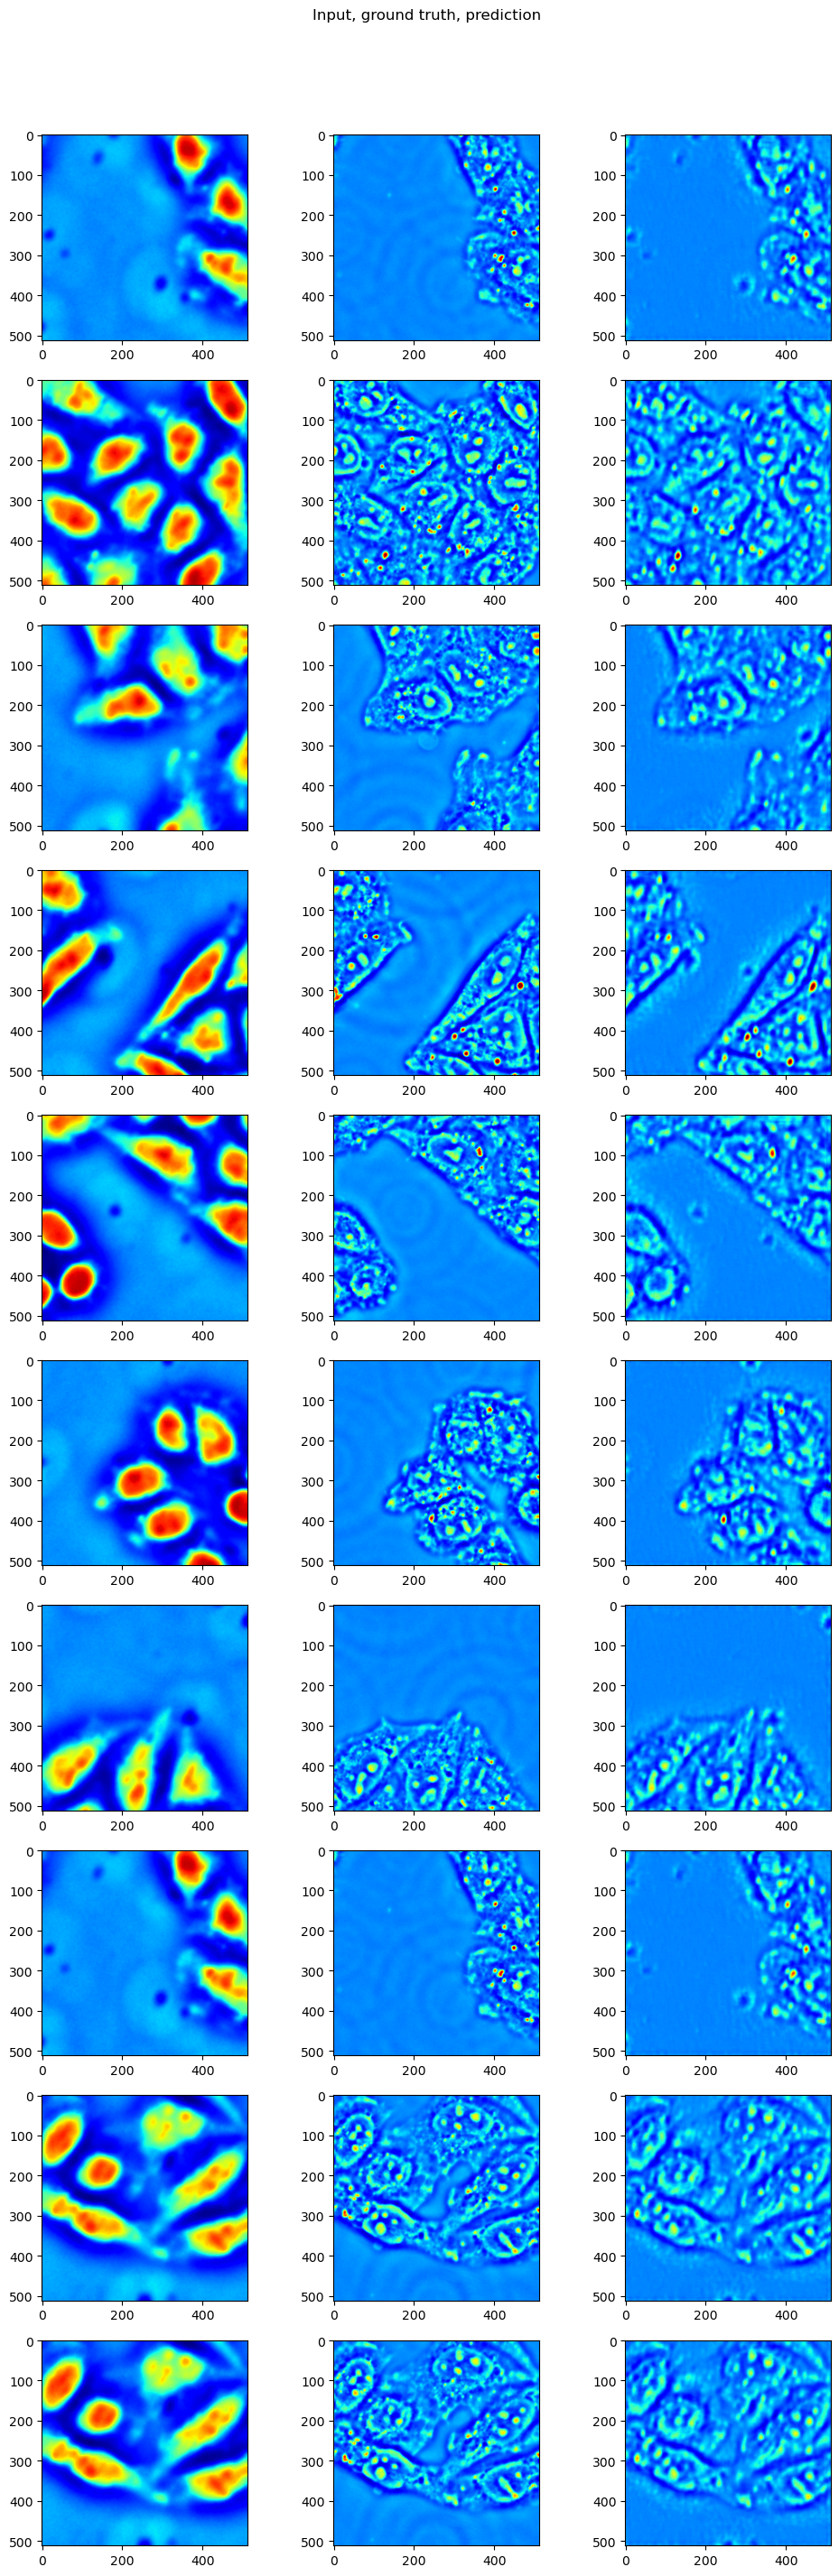

In [14]:
model2=model_g.to(device)
model2.eval()
t1=transforms.Grayscale(num_output_channels=1)
_, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
plt.suptitle('Input, ground truth, prediction') 
q=np.random.randint(0,len(test_loader),10)
data=test_loader.dataset
model2.eval()
with torch.no_grad():
    for i,j in enumerate(q):
        x1,y1=data[j]
        x1=x1.to(device)
        y1=y1.to(device)
        pred=model2(torch.unsqueeze(x1, 0))
        x,y,p=rescale_phase(x1,y1,pred,-2,2)
        plt.subplot(10,3,3*(i)+1)
        plt.imshow(np.squeeze(np.squeeze(t1(x).cpu(),0),0),cmap='jet',vmin=-0.6,vmax=1.7)
        plt.subplot(10,3,3*(i)+2)
        plt.imshow(np.squeeze(np.squeeze(t1(y).cpu(),0),0),cmap='jet',vmin=-0.6,vmax=1.7)
        plt.subplot(10,3,3*(i)+3)
        plt.imshow(np.squeeze(np.squeeze(t1(p).cpu(),0),0),cmap='jet',vmin=-0.6,vmax=1.7)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])    


In [12]:
def rescale_phase(x,y,p,a,b):
    x=x*(b-a)+a
    y=(y+1)*0.5*(b-a)+a
    p=(p+1)*0.5*(b-a)+a
    return x,y,p